# Lesson 9 - FastAI

In [4]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [5]:
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
!echo '{"username":"unadeem","key":"ed1df5a2cd97f9d82e42c37511c02095"}' > /root/.kaggle/kaggle.json

In [153]:
!kaggle competitions download -c bluebook-for-bulldozers #Downloading data from Kaggle

bluebook-for-bulldozers.zip: Skipping, found more recently modified local copy (use --force to force download)


## Tabular Modeling Deep Dive
We will be creating a tabular model that predicts salesprice. 

### Unzipping data

In [155]:
import zipfile

z= zipfile.ZipFile('bluebook-for-bulldozers.zip') #unzip first
z.extractall() #extract

## Look at the Data

In [3]:
df = pd.read_csv('TrainAndValid.csv', low_memory=False) #get data from csv file

In [9]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [10]:
df['ProductSize'].unique() #Lets view this oridnal colomn

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

> Notice that these seem to be in random order, we should fix this as order has value

In [11]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact' #our desired order

In [12]:
df['ProductSize'] = df['ProductSize'].astype('category') #Turn into categorical variable

df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True) #Now we can set our order

In [13]:
df['ProductSize'].unique() 

[NaN, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact']
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In [12]:
dep_var = 'SalePrice' #our label

In [13]:
df[dep_var] = np.log(df[dep_var]) #kaggle wants us to do MNSLE, so we must take log

## Decision Trees
A decision tree asks a series of binary question (Yes or No) about the data. Below is an image demostrating a dicision tree:

![image](https://lh4.googleusercontent.com/v9UQUwaQTAXVH90b-Ugyw2_61_uErfYvTBtG-RNRNB_eHUFq9AmAN_2IOdfOETnbXImnQVN-wPC7_YzDgf7urCeyhyx5UZmuSwV8BVsV8VnHxl1KtgpuxDifJ4pLE23ooYXLlnc)

> We actually don't know how to come up with these question, so we have the model do it for us!

### Handling Dates
We need to handle dates a little differently. Because they don't provide much information, we use feature engineering to create my specific categories. Feature engineering is taken care of by FastAI ToolKit add_datepart.

In [4]:
df = add_datepart(df, 'saledate')

In [17]:
' '.join(o for o in df.columns if o.startswith('sale')) 

'saleWeek saleYear saleMonth saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

> Notice the many distinct categories

In [19]:
df_test = pd.read_csv(Path()/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate') #Doing the same for test dataset

## Using TabularPandas and TabularProc
We actually need to clean our data a little more. Will be using a transform, **TabularProc**: Specifically **Categorify** and **FillMissing**. Categorify replaces columns with numerical categorical columns, and FillMissing replaces missing values with the median of the column.  

In [83]:
procs = [Categorify, FillMissing]

### Creating our validation set
Below we want to split our data by date, where the last couple of weeks of data is used for the validation set. We want to split our data by **date** this time and **not randomly** because date is a major factor in the prediction. 

In [5]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [10]:
len(cond), len(train_idx), len(valid_idx)

(412698, 404710, 7988)

### Seperating data
We also need to seperate the continous data from the categorical. We can also do this using FastAI

In [14]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var) #Also pass our label so it isnt included

In [23]:
cont[:4]

['SalesID', 'MachineID', 'ModelID', 'datasource']

In [24]:
cat[:4]

['saleWeek', 'UsageBand', 'fiModelDesc', 'fiBaseModel']

### TabularPandas
Now we can take everything we did above and throw it into the Tabular Object

In [86]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [87]:
len(to.train),len(to.valid) 

(404710, 7988)

In [47]:
to.show(3) #We can view our data similer to DataLoader

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,NaN
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,NaN
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,NaN


In [49]:
to.items.head(3)

,SalesID,SalePrice,MachineID,saleWeek,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,NaN,999089,46,...,1,2647,1,1
1,1139248,NaN,117657,13,...,1,2148,1,1
2,1139249,NaN,434808,9,...,1,2131,1,1


In [48]:
#Lets view only a few columns
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,NaN
1,North Carolina,WL,#na#,EROPS w AC,NaN
2,New York,SSL,#na#,OROPS,NaN


> It shows strings, but it's actually stored internally as digits. See below:

In [50]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


> These values are referring to the vocab

In [56]:
to.classes['ProductSize'] 

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [26]:
save_pickle(Path()/'to.pkl',to)

> Lets also export what we currently have, so we don't have to rerun the processing

## Creating the Decision Tree

In [8]:
#hide
to = load_pickle(Path()/'to.pkl') #Load it back

In [9]:
#Grab our x,y
xs,y = to.train.xs,to.train.y 
valid_xs,valid_y = to.valid.xs,to.valid.y

In [5]:
m = DecisionTreeRegressor(max_leaf_nodes=4) #Creating tree
m.fit(xs, y) #Fitting

DecisionTreeRegressor(max_leaf_nodes=4)

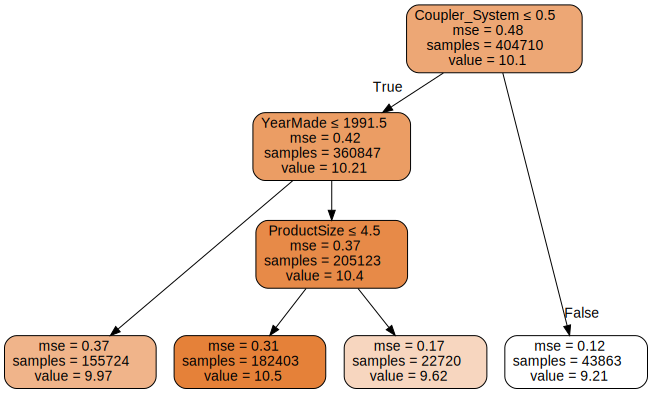

In [6]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

**We can also view the above information using another library**

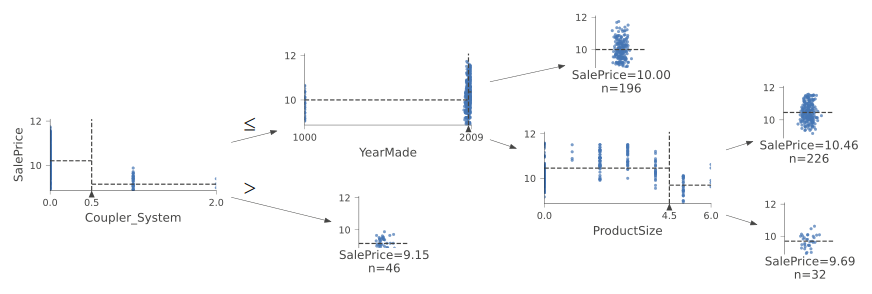

In [9]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, 'SalePrice',
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

> Notice that here we can see that their are models made in the 1000's which is obv not true: We can fix this

In [11]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

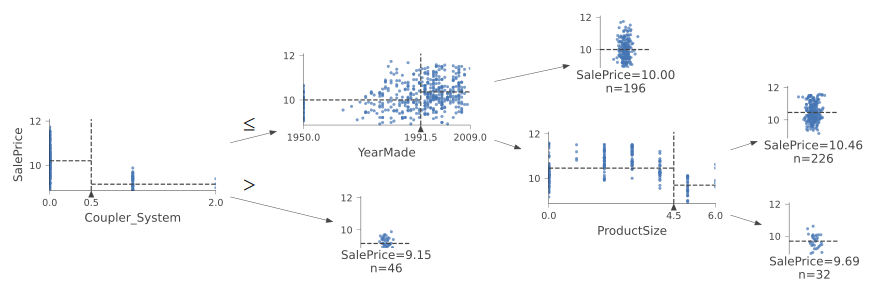

In [13]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, 'SalePrice',
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

> Now it looks a little cleaner

In [14]:
#lets make a bigger dicision tree: To do this remove the maximum limit
m = DecisionTreeRegressor()
m.fit(xs, y);

In [2]:
#Functions will be using to calc error
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

### Lets test our model 

In [16]:
m_rmse(m, xs, y)

0.0

> We got 0! Does that mean our model is perfect? No, as you will see below the validation performs worse. We are overfitting.

In [17]:
m_rmse(m, valid_xs, valid_y)

0.332418

In [18]:
m.get_n_leaves(), len(xs) #lets view how many leaves we have

(324542, 404710)

> We seem to have just as much leave nodes as data

### Lets fix our tree and retrain
Lets change the hyperparameter and see if it improves the performance.

In [19]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248593, 0.323419)

In [20]:
m.get_n_leaves()

12397

> It seems like we are just guessing, maybe there is a better way to choose (Similer to the LR finder).

# Random Forests
This idea is similer to LR finder, where we take minibatches and train it. Here we subset the data items (the rows) and we subset the fields (the columns). 

In [ ]:
#hide
# pip install —pre -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn —U

### Creating a Random Forest

**n_estimators** defines the number of trees we want, **max_samples** defines how many rows to sample for training each tree, and **max_features** defines how many columns to sample at each split point (where 0.5 means "take half the total number of columns"). We can also specify when to stop splitting the tree nodes by including  **min_samples_leaf**. Finally, we pass **n_jobs=-1** to tell sklearn to use all our CPUs to build the trees in parallel.

In [1]:
#Method below creates our random forest and fits it
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                max_samples=max_samples, max_features=max_features,
                                min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [32]:
m = rf(xs, y);

In [33]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170752, 0.232851)

> Our valid has improved

In [34]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [35]:
r_mse(preds.mean(0), valid_y)

0.232851

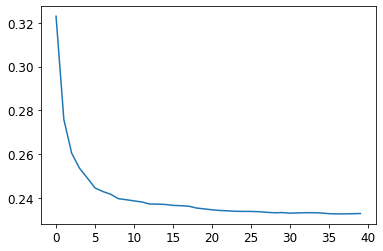

In [36]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

## Out-of-Bag Error
In the above training, you may have noticed that although the validation did well, it performed worse in comparison to the training. We can determine if this is a case of overfitting or something else by using OOB error.

The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was not included in training. This allows us to see whether the model is overfitting, without needing a separate validation set.

In [37]:
r_mse(m.oob_prediction_, y)

0.210522

## Sidebar: Model Interpretation
For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

Let's start with the first one!

### Tree Variance for Prediction Confidence

In [38]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_]) #Grab all predictions

In [41]:
preds.shape

(40, 7988)

In [43]:
preds_std = preds.std(0) #Take standard dev across all (dim=0)

In [44]:
preds_std[:5]

array([0.29684344, 0.11715659, 0.09982913, 0.28225758, 0.10176538])

> It seems like the pred vary quite a lot. This can hint toward lower confidence

### Feature Importance

In [8]:
#Method that returns most important features
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [46]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
59,YearMade,0.177578
31,Coupler_System,0.128965
7,ProductSize,0.109147
8,fiProductClassDesc,0.080394
33,Hydraulics_Flow,0.061755
56,ModelID,0.058135
51,saleElapsed,0.051770
4,fiSecondaryDesc,0.043525
2,fiModelDesc,0.033589
54,SalesID,0.024917


> These are the 10 most important features

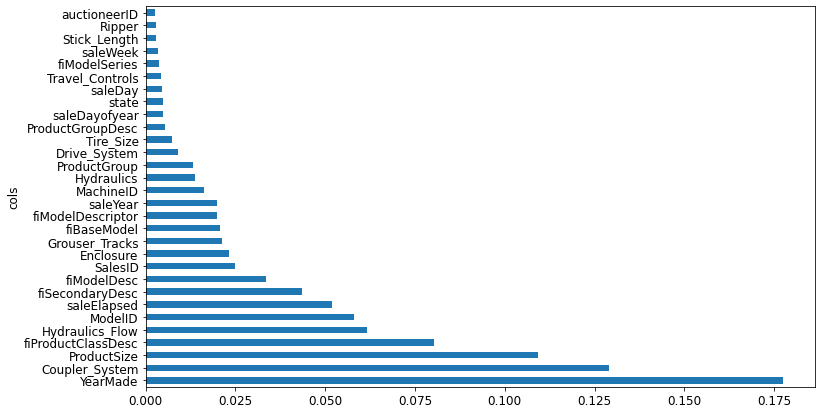

In [47]:
#We can also plot them
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Removing Low-Importance Variables
Lets retrain the model with only the important variables

In [56]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [64]:
to_keep

59              YearMade
31        Coupler_System
7            ProductSize
8     fiProductClassDesc
33       Hydraulics_Flow
             ...        
24            Hydraulics
10          ProductGroup
12          Drive_System
29             Tire_Size
11      ProductGroupDesc
Name: cols, Length: 21, dtype: object

In [65]:
#Only grabbing the important col
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [66]:
m = rf(xs_imp, y) #fitting

In [67]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181614, 0.231854)

> Notice same results, but with much fewer columns

In [68]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

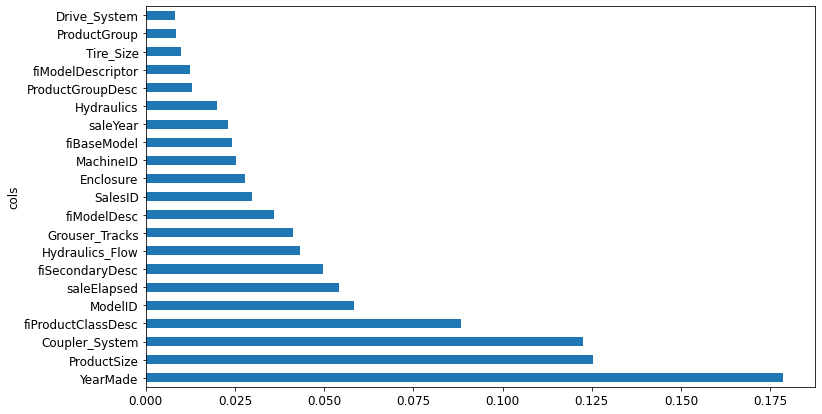

In [69]:
plot_fi(rf_feat_importance(m, xs_imp));

### Removing Redundant Features

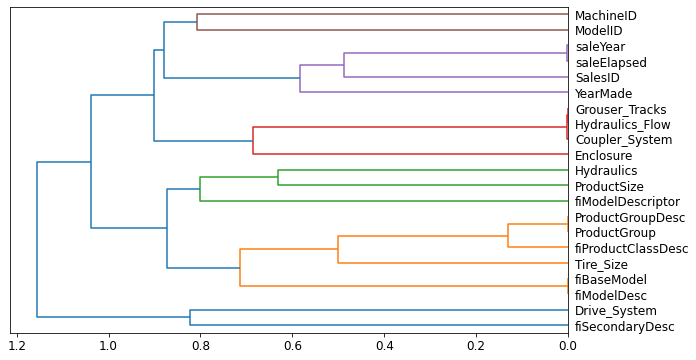

In [70]:
cluster_columns(xs_imp) #This method creates clusters for us

In [7]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [72]:
get_oob(xs_imp)

0.8768766300713627

In [73]:
#Now lets drop these columns 1 at a time
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8765064361622091,
 'saleElapsed': 0.8723616014457026,
 'ProductGroupDesc': 0.8766195232652162,
 'ProductGroup': 0.8778533737393852,
 'fiModelDesc': 0.8756466820705895,
 'fiBaseModel': 0.8772457507706705,
 'Hydraulics_Flow': 0.877162325587534,
 'Grouser_Tracks': 0.8773995836616898,
 'Coupler_System': 0.8781344943040315}

In [74]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8749910789330729

> Notice that even after dropping 5 columns, we recieved very similer score

In [75]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [78]:
save_pickle(Path()/'xs_final.pkl', xs_final)
save_pickle(Path()/'valid_xs_final.pkl', valid_xs_final)

In [6]:
xs_final = load_pickle(Path()/'xs_final.pkl')
valid_xs_final = load_pickle(Path()/'valid_xs_final.pkl')

In [10]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183687, 0.233937)

### Partial Dependence

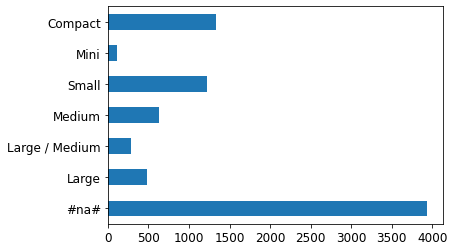

In [81]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

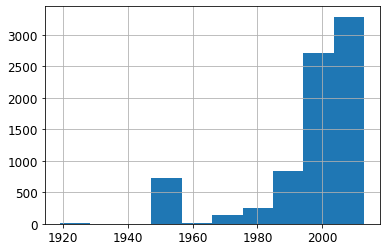

In [82]:
ax = valid_xs_final['YearMade'].hist()

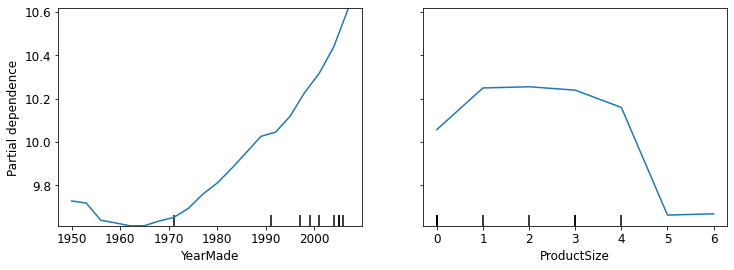

In [83]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

### Tree Interpreter

In [84]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [85]:
row = valid_xs_final.iloc[:5]

In [86]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [87]:
prediction[0], bias[0], contributions[0].sum()

(array([9.97289227]), 10.104706206311942, -0.13181393330974048)

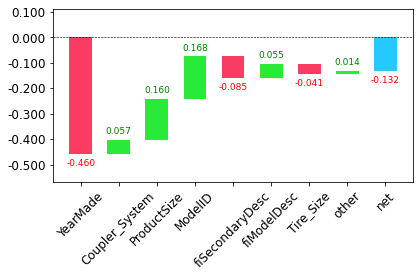

In [88]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

## End Sidebar

## Sidebar: The Extrapolation Problem

In [89]:
#hide
np.random.seed(42)

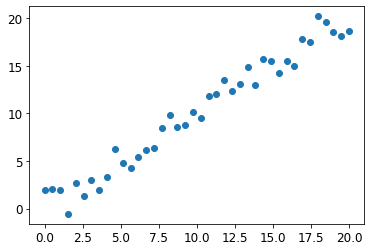

In [15]:
#lets assume we have this dataset
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [16]:
xs_lin = x_lin.unsqueeze(1) #Must add another dim
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [92]:
x_lin[:,None].shape #Another way

torch.Size([40, 1])

In [93]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30]) #Train

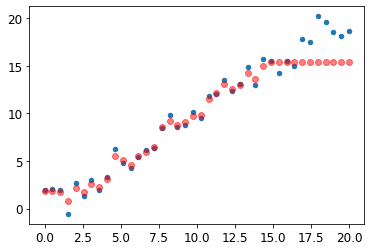

In [94]:
#Prediction
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

> This is odd, why does our predictions look like that at the end?

#### Why?
Remember, a random forest just averages the predictions of a number of trees. And a tree simply predicts the average value of the rows in a leaf. Therefore, a tree and a random forest can never predict values outside of the range of the training data. That's why we need to make sure our validation set does not contain out-of-domain data.

### Finding Out-of-Domain Data
We can find these out of domain data by doing the following:

In [95]:
df_dom = pd.concat([xs_final, valid_xs_final]) #Concat of training and valid
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final)) #dependent var

m = rf(df_dom, is_valid) 
rf_feat_importance(m, df_dom)[:6] 

,cols,imp
6,saleElapsed,0.888724
9,SalesID,0.094268
12,MachineID,0.011024
0,YearMade,0.001854
5,ModelID,0.000571
3,fiProductClassDesc,0.000541


> So these top 3 columns most different between the training and validation set

In [19]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.231293
SalesID 0.230695
saleElapsed 0.235358
MachineID 0.230651


> Seems like we can remove the SalesID and MachineiD

In [20]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.229106

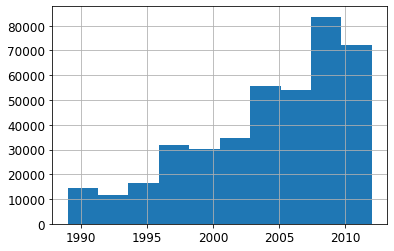

In [21]:
xs['saleYear'].hist();

> Seems like most of the sales were after 2004, why don't we only look at that data

In [22]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [23]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.177593, 0.229799)

## End Sidebar

# Using a Neural Network
So far we have been using random forest and have been fitting it. We can also do this problem using a NN. Below will switch to using a NN.

### Grabbing initial data
Like before, lets just grab everything we need

In [14]:
df_nn = pd.read_csv(Path()/'TrainAndValid.csv', low_memory=False) #Data

#Set ordinal variables using our order
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

dep_var = 'SalePrice'
df_nn[dep_var] = np.log(df_nn[dep_var]) #remember we need to take log of the label (Kaggle requires)
df_nn = add_datepart(df_nn, 'saledate') #Also remember that we used feature engineering on date 

In [16]:
df_nn.shape #currently we have 65 col

(412698, 65)

In [19]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]] #lets drop the col down to the 15 we found earlier + the dep_var

In [20]:
df_nn_final.shape #now were down to our orig 16 col

(412698, 16)

In [104]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var) #Max_card makes it so that any col with more than
                                                                            # 9000 lvls, it will be treated as cont

In [105]:
cont_nn

[]

> There's one variable that we absolutely do not want to treat as categorical: the saleElapsed variable

In [106]:
cont_nn.append('saleElapsed') #lets add that
cont_nn

['saleElapsed']

In [107]:
cat_nn.remove('saleElapsed') #Remove from cat

**Lets take a look at the carinality of each categorical data**

In [108]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
Hydraulics_Flow          3
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Enclosure                6
fiModelDescriptor      140
Hydraulics              12
ProductGroup             6
Drive_System             4
Tire_Size               17
dtype: int64

> Seems like fiModelDescriptor and fiModelDesc are similer, lets see if we can remove one them

In [137]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)#Drop on train
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)#Drop on val

m2 = rf(xs_filt2, y_filt) #create random forest
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y) #test

(0.17662, 0.230076)

> Seems like we can remove it!

In [110]:
cat_nn.remove('fiModelDescriptor') #remove

### Creating dataloader
Like before we will create our TabularPandas Object. However, this time our procs has Normalize: This is added because NN are actually affected by the distribution of data due to their linear layers.

In [118]:
procs_nn = [Categorify, FillMissing, Normalize]

to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)

> If you get an error of 'Value Error: Unable to coerce to Series', try changing saleElapsed to int64 
```python
    df_nn_final.dtypes
    df_nn_final['saleElapsed'] = df_nn_final['saleElapsed'].astype('int') 
```


In [119]:
dls = to_nn.dataloaders(1024) #lets create minibatchs of size 1024

In [120]:
#lets also get the y-range as this is a regression model
y = to_nn.train.y
y.min(),y.max()

(8.465899, 11.863583)

### Training

In [121]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.00015848931798245758)

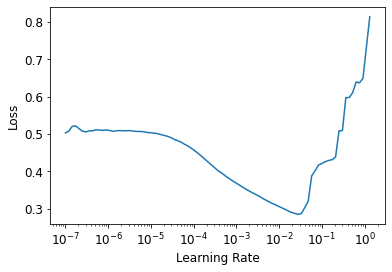

In [122]:
learn.lr_find() #find best lr

In [123]:
learn.fit_one_cycle(5, 1e-2) #train

epoch,train_loss,valid_loss,time
0,0.069279,0.061849,00:09
1,0.056090,0.055828,00:09
2,0.048482,0.055626,00:09
3,0.043522,0.051739,00:09
4,0.040515,0.051112,00:09


In [124]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.22608

> Seems like it did better than the random forest fit

In [ ]:
learn.save('nn') #save model

## Ensembling
Both the random forest and NN have their benifits. Well we can actually get the best of both worlds by using an ensemble!

In [151]:
rf_preds = m2.predict(valid_xs_time2) #grab random forest pred

ens_preds = (to_np(preds.squeeze()) + rf_preds) /2 #Take the average of our 2 pred

In [152]:
r_mse(ens_preds,valid_y)

0.22251

> Compare this with the last result :)

## Conclusion
Well I hoped you learn how to do tabular modeling using both a random forest and NN. They both have their own benefits.

## Questionnaire

1. **What is a continuous variable?**  
A numerical value that is continous, such as age. 
1. **What is a categorical variable?**  
An ordinal data, or data with discrete levels.
1. **Provide two of the words that are used for the possible values of a categorical variable.**  
ordinal variable and categorical variable.
1. **What is a "dense layer"?**  
Linear layers
1. **How do entity embeddings reduce memory usage and speed up neural networks?**  
Entity embeddings allows the indexing of data to be much more memory-efficient.
1. **What kinds of datasets are entity embeddings especially useful for?**  
Datasets with high levels of cardinality
1. **What are the two main families of machine learning algorithms?**  
Ensemble of decision trees are best for structured data (Ex tabular)  
Multilayered neural networks are best for unstructured data (Ex vision)
1. **Why do some categorical columns need a special ordering in their classes? How do you do this in Pandas?**  
These are ordinal data. To do this, we create our own order and pass it through. 
```python
    sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact' #our desired order
    df['ProductSize'] = df['ProductSize'].astype('category') #Turn into categorical variable

    df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True) #Now we can set our order
```
1. **Summarize what a decision tree algorithm does.**  
Series of yes and no questions, which it used to determine how to group the data. Here is the algorithm given in the book:  
- Loop through each column of the dataset in turn
- For each column, loop through each possible level of that column in turn
- Try splitting the data into two groups, based on whether they are greater than or less than that value (or if it is a - categorical variable, based on whether they are equal to or not equal to that level of that categorical variable)
- Find the average sale price for each of those two groups, and see how close that is to the actual sale price of each of the items of equipment in that group. That is, treat this as a very simple “model” where our predictions are simply the average sale price of the item’s group
- After looping through all of the columns and possible levels for each, pick the split point which gave the best predictions using our very simple model
- We now have two different groups for our data, based on this selected split. Treat each of these as separate datasets, and find the best split for each, by going back to step one for each group
- Continue this process recursively, and until you have reached some stopping criterion for each group — for instance, stop splitting a group further when it has only 20 items in it.
1. **Why is a date different from a regular categorical or continuous variable, and how can you preprocess it to allow it to be used in a model?**  
Dates are different from other cetegorical/continuous data (Ex: some are holidays). Therefore, we can generate many different categorical features about the given date (ex: Is it the end of the month?)
1. **Should you pick a random validation set in the bulldozer competition? If no, what kind of validation set should you pick?**   
You should not because here the date plays a major part as the test set contains data of the last 2 weeks. Therefore, we should split the data by the dates and include the later dates in the validation set. 
1. **What is pickle and what is it useful for?**  
Allows you so save any Python object as a file.
1. **How are `mse`, `samples`, and `values` calculated in the decision tree drawn in this chapter?**  
By traversing the tree (based on answering questions about the data), we reach the nodes that tell us the average value of the data in that group.
1. **How do we deal with outliers, before building a decision tree?**  
We can use random forest. But in this case we don’t use a random forest to predict our actual dependent variable. Instead we try to predict whether a row is in the validation set, or the training set.
1. **How do we handle categorical variables in a decision tree?**  
We convert it into a numerical value that references the vocab.
1. **What is bagging?**  
Training multiple models on random subsets of the data, and use the ensemble of models for prediction.
1. **What is the difference between `max_samples` and `max_features` when creating a random forest?**  
max_samples defines how many  rows of the tabular dataset we use for each decision tree.  
max_features defines how many columns of the tabular dataset we use for each decision tree.
1. **If you increase `n_estimators` to a very high value, can that lead to overfitting? Why or why not?**  
No as the trees are independent of one another.
1. **In the section "Creating a Random Forest", just after <<max_features>>, why did `preds.mean(0)` give the same result as our random forest?**  
Because much like the Random Forest that took the mean of the ensemble, we stacked all the dicision trees and took the mean across all the trees (dim=0).
1. **What is "out-of-bag-error"?**  
The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was not included in training. This allows us to see whether the model is overfitting, without needing a separate validation set.
1. **Make a list of reasons why a model's validation set error might be worse than the OOB error. How could you test your hypotheses?**  
Overfitting  
Validation has different distribution  

One way you can solve the distribution problem is by checking the standard deviation on the predictions.
1. **Explain why random forests are well suited to answering each of the following question:**  
   - **How confident are we in our predictions using a particular row of data?**  
   Check the standard deviation on the predictions.
   - **For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?**  
   Check how the prediction changes as it goes through the tree, adding up the contributions from each split/feature. Use waterfall plot to visualize.
   - **Which columns are the strongest predictors?**  
   This is done by using feature_importance_
   - **How do predictions vary as we vary these columns?**  
   Partial dependence plots
1. **What's the purpose of removing unimportant variables?**  
Improve model as its more interpertable with less clutering. Also, sometimes unnessary data can scew the prediction.
1. **What's a good type of plot for showing tree interpreter results?**  
Waterfall plot
1. **What is the "extrapolation problem"?**  
This was a demonstration of how a random forests cannot predict outside the domain of the training data. However, NN can generalize better due to their linear layers.
1. **How can you tell if your test or validation set is distributed in a different way than your training set?**  
We can do so by training a model to classify if the data is training or validation data. If the data is of different distributions (out-of-domain data), then the model can properly classify between the two datasets.
1. **Why do we ensure `saleElapsed` is a continuous variable, even although it has less than 9,000 distinct values?**  
We want to make this a continuous variable as we want our model to determine future sales.
1. **What is "boosting"?**  
We train a model that underfits the dataset, and train subsequent models that predicts the error of the original model. We then add the predictions of all the models to get the final prediction.
1. **How could we use embeddings with a random forest? Would we expect this to help?**  
Instead of passing raw categorical columns, we can pass entity embeddings into the random forest model: This is better as embedding contain better representations of the features and will, in turn, improve the performance.
1. **Why might we not always use a neural net for tabular modeling?**  
We might not use them because they are harder and longer to train. 

### Further Research

1. **Pick a competition on Kaggle with tabular data (current or past) and try to adapt the techniques seen in this chapter to get the best possible results. Compare your results to the private leaderboard.**  
Completed, see https://usama280.github.io/PasteBlogs/ (Tabular on Lesson 8)
1. **Implement the decision tree algorithm in this chapter from scratch yourself, and try it on the dataset you used in the first exercise.**  
1. **Use the embeddings from the neural net in this chapter in a random forest, and see if you can improve on the random forest results we saw.**  
Completed, see https://usama280.github.io/PasteBlogs/ (EmbeddingRandomForest)
1. **Explain what each line of the source of `TabularModel` does (with the exception of the `BatchNorm1d` and `Dropout` layers).**  